In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
import torch
import os

In [2]:
# 設置環境變量以啟用 MPS 後備
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# 檢查 MPS 是否可用
device = (
    "mps" 
    if torch.backends.mps.is_available() 
    else "cpu"
)
print(f"Using device: {device}")

Using device: mps


In [3]:
# 讀取CSV文件
df = pd.read_csv('../input/training_balanced.csv')
df = df.rename(columns={'HasTransaction': 'labels'})

# 將數據分為訓練集和驗證集
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# 將DataFrame轉換為Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [4]:
display(train_dataset)

Dataset({
    features: ['Content', 'labels', '__index_level_0__'],
    num_rows: 314
})

In [5]:
display(val_dataset)

Dataset({
    features: ['Content', 'labels', '__index_level_0__'],
    num_rows: 79
})

In [6]:
# 設置tokenizer
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [7]:
def preprocess_function(examples):
    # 為T5添加特定的前綴
    inputs = [f"classify transaction: {text}" for text in examples["Content"]]
    # 將標籤轉換為文本格式
    targets = [str(label) for label in examples["labels"]]
    
    model_inputs = tokenizer(
        inputs, 
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    
    # 對標籤進行編碼
    labels = tokenizer(
        targets,
        max_length=8,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [8]:
# 對數據集應用預處理
tokenized_train = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
tokenized_val = val_dataset.map(preprocess_function, batched=True, remove_columns=val_dataset.column_names)

Map:   0%|          | 0/314 [00:00<?, ? examples/s]

Map:   0%|          | 0/79 [00:00<?, ? examples/s]

In [9]:
display(tokenized_train)

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 314
})

In [10]:
display(tokenized_val)

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 79
})

In [11]:
# 設置基礎模型
base_model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
).to(device)

In [12]:
# 配置LoRA
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,  # T5是序列到序列模型
    inference_mode=False,
    r=256,                    # 從 8 提高到 256
    lora_alpha=512,  
    lora_dropout=0.1,
    target_modules=["q", "v", "k", "o", "gate", "up", "down"]  # 增加更多目標模組
)

In [13]:
# 創建PEFT模型
model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

trainable params: 56,623,104 || all params: 304,200,960 || trainable%: 18.6137


In [14]:
# 定義訓練參數
training_args = TrainingArguments(
    output_dir="../output/lora_results",
    num_train_epochs=100,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    warmup_steps=500,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    auto_find_batch_size=True
)

In [15]:
# 設置Trainer並開始訓練
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
)

# 訓練前禁用快取以避免警告
model.config.use_cache = False

/var/folders/jb/j6r5nys57yd6l7l9kbbbqlsh5f4v0p/T/ipykernel_58808/2708656994.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
# 訓練模型
train_result = trainer.train()

  0%|          | 0/3900 [00:00<?, ?it/s]

{'loss': 40.1734, 'grad_norm': 100.5905532836914, 'learning_rate': 2.0000000000000002e-07, 'epoch': 0.25}
{'loss': 39.6266, 'grad_norm': 119.31454467773438, 'learning_rate': 4.0000000000000003e-07, 'epoch': 0.51}
{'loss': 39.8922, 'grad_norm': 114.58261108398438, 'learning_rate': 6.000000000000001e-07, 'epoch': 0.76}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 41.8125, 'eval_runtime': 4.0705, 'eval_samples_per_second': 19.408, 'eval_steps_per_second': 4.913, 'epoch': 0.99}
{'loss': 38.225, 'grad_norm': 93.20215606689453, 'learning_rate': 8.000000000000001e-07, 'epoch': 1.01}
{'loss': 39.3906, 'grad_norm': 97.97002410888672, 'learning_rate': 1.0000000000000002e-06, 'epoch': 1.27}
{'loss': 37.2766, 'grad_norm': 84.2933349609375, 'learning_rate': 1.2000000000000002e-06, 'epoch': 1.52}
{'loss': 37.7844, 'grad_norm': 111.72199249267578, 'learning_rate': 1.4000000000000001e-06, 'epoch': 1.77}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 39.15625, 'eval_runtime': 3.7404, 'eval_samples_per_second': 21.121, 'eval_steps_per_second': 5.347, 'epoch': 2.0}
{'loss': 37.8469, 'grad_norm': 97.0112533569336, 'learning_rate': 1.6000000000000001e-06, 'epoch': 2.03}
{'loss': 36.6422, 'grad_norm': 76.27106475830078, 'learning_rate': 1.8000000000000001e-06, 'epoch': 2.28}
{'loss': 36.4453, 'grad_norm': 69.47300720214844, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.53}
{'loss': 34.9875, 'grad_norm': 79.92808532714844, 'learning_rate': 2.2e-06, 'epoch': 2.78}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 35.09375, 'eval_runtime': 3.7336, 'eval_samples_per_second': 21.159, 'eval_steps_per_second': 5.357, 'epoch': 2.99}
{'loss': 35.2781, 'grad_norm': 68.83483123779297, 'learning_rate': 2.4000000000000003e-06, 'epoch': 3.04}
{'loss': 33.4789, 'grad_norm': 64.78730010986328, 'learning_rate': 2.6e-06, 'epoch': 3.29}
{'loss': 32.15, 'grad_norm': 62.11085891723633, 'learning_rate': 2.8000000000000003e-06, 'epoch': 3.54}
{'loss': 32.7289, 'grad_norm': 45.883880615234375, 'learning_rate': 3e-06, 'epoch': 3.8}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 30.25, 'eval_runtime': 3.765, 'eval_samples_per_second': 20.983, 'eval_steps_per_second': 5.312, 'epoch': 4.0}
{'loss': 30.6133, 'grad_norm': 55.18882369995117, 'learning_rate': 3.2000000000000003e-06, 'epoch': 4.05}
{'loss': 30.3492, 'grad_norm': 48.912132263183594, 'learning_rate': 3.4000000000000005e-06, 'epoch': 4.3}
{'loss': 29.2063, 'grad_norm': 52.288780212402344, 'learning_rate': 3.6000000000000003e-06, 'epoch': 4.56}
{'loss': 27.6359, 'grad_norm': 42.62075424194336, 'learning_rate': 3.8000000000000005e-06, 'epoch': 4.81}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 24.6875, 'eval_runtime': 3.7219, 'eval_samples_per_second': 21.226, 'eval_steps_per_second': 5.374, 'epoch': 4.99}
{'loss': 26.8352, 'grad_norm': 44.083831787109375, 'learning_rate': 4.000000000000001e-06, 'epoch': 5.06}
{'loss': 25.3055, 'grad_norm': 38.556060791015625, 'learning_rate': 4.2000000000000004e-06, 'epoch': 5.32}
{'loss': 23.7602, 'grad_norm': 33.51295471191406, 'learning_rate': 4.4e-06, 'epoch': 5.57}
{'loss': 22.7688, 'grad_norm': 31.403440475463867, 'learning_rate': 4.600000000000001e-06, 'epoch': 5.82}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 19.265625, 'eval_runtime': 3.7505, 'eval_samples_per_second': 21.064, 'eval_steps_per_second': 5.333, 'epoch': 6.0}
{'loss': 21.732, 'grad_norm': 30.325977325439453, 'learning_rate': 4.800000000000001e-06, 'epoch': 6.08}
{'loss': 20.5867, 'grad_norm': 25.843229293823242, 'learning_rate': 5e-06, 'epoch': 6.33}
{'loss': 19.7641, 'grad_norm': 34.41262435913086, 'learning_rate': 5.2e-06, 'epoch': 6.58}
{'loss': 18.3156, 'grad_norm': 21.72047233581543, 'learning_rate': 5.400000000000001e-06, 'epoch': 6.84}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 14.640625, 'eval_runtime': 3.7354, 'eval_samples_per_second': 21.149, 'eval_steps_per_second': 5.354, 'epoch': 6.99}
{'loss': 17.3125, 'grad_norm': 28.68633270263672, 'learning_rate': 5.600000000000001e-06, 'epoch': 7.09}
{'loss': 15.8715, 'grad_norm': 29.30625343322754, 'learning_rate': 5.8e-06, 'epoch': 7.34}
{'loss': 14.3832, 'grad_norm': 35.909149169921875, 'learning_rate': 6e-06, 'epoch': 7.59}
{'loss': 12.3832, 'grad_norm': 46.26340103149414, 'learning_rate': 6.200000000000001e-06, 'epoch': 7.85}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 7.55859375, 'eval_runtime': 3.7316, 'eval_samples_per_second': 21.171, 'eval_steps_per_second': 5.36, 'epoch': 8.0}
{'loss': 10.1742, 'grad_norm': 49.361839294433594, 'learning_rate': 6.4000000000000006e-06, 'epoch': 8.1}
{'loss': 8.9816, 'grad_norm': 25.658538818359375, 'learning_rate': 6.600000000000001e-06, 'epoch': 8.35}
{'loss': 8.4639, 'grad_norm': 14.656781196594238, 'learning_rate': 6.800000000000001e-06, 'epoch': 8.61}
{'loss': 7.9826, 'grad_norm': 12.915969848632812, 'learning_rate': 7e-06, 'epoch': 8.86}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 6.80859375, 'eval_runtime': 3.715, 'eval_samples_per_second': 21.265, 'eval_steps_per_second': 5.384, 'epoch': 8.99}
{'loss': 7.5811, 'grad_norm': 17.833148956298828, 'learning_rate': 7.2000000000000005e-06, 'epoch': 9.11}
{'loss': 7.2502, 'grad_norm': 9.3274564743042, 'learning_rate': 7.4e-06, 'epoch': 9.37}
{'loss': 6.8455, 'grad_norm': 13.799182891845703, 'learning_rate': 7.600000000000001e-06, 'epoch': 9.62}
{'loss': 6.4105, 'grad_norm': 9.802205085754395, 'learning_rate': 7.800000000000002e-06, 'epoch': 9.87}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 5.09375, 'eval_runtime': 3.8101, 'eval_samples_per_second': 20.734, 'eval_steps_per_second': 5.249, 'epoch': 10.0}
{'loss': 6.0014, 'grad_norm': 10.303955078125, 'learning_rate': 8.000000000000001e-06, 'epoch': 10.13}
{'loss': 5.5254, 'grad_norm': 17.281333923339844, 'learning_rate': 8.2e-06, 'epoch': 10.38}
{'loss': 4.8797, 'grad_norm': 14.47922134399414, 'learning_rate': 8.400000000000001e-06, 'epoch': 10.63}
{'loss': 4.3158, 'grad_norm': 11.606026649475098, 'learning_rate': 8.6e-06, 'epoch': 10.89}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 3.705078125, 'eval_runtime': 3.7675, 'eval_samples_per_second': 20.969, 'eval_steps_per_second': 5.308, 'epoch': 10.99}
{'loss': 4.1242, 'grad_norm': 8.94244384765625, 'learning_rate': 8.8e-06, 'epoch': 11.14}
{'loss': 3.8644, 'grad_norm': 8.253856658935547, 'learning_rate': 9e-06, 'epoch': 11.39}
{'loss': 3.7428, 'grad_norm': 6.250693321228027, 'learning_rate': 9.200000000000002e-06, 'epoch': 11.65}
{'loss': 3.7193, 'grad_norm': 10.075949668884277, 'learning_rate': 9.4e-06, 'epoch': 11.9}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 3.337890625, 'eval_runtime': 3.7724, 'eval_samples_per_second': 20.942, 'eval_steps_per_second': 5.302, 'epoch': 12.0}
{'loss': 3.5595, 'grad_norm': 10.007322311401367, 'learning_rate': 9.600000000000001e-06, 'epoch': 12.15}
{'loss': 3.4178, 'grad_norm': 8.970113754272461, 'learning_rate': 9.800000000000001e-06, 'epoch': 12.41}
{'loss': 3.2746, 'grad_norm': 7.956885814666748, 'learning_rate': 1e-05, 'epoch': 12.66}
{'loss': 3.2659, 'grad_norm': 10.274398803710938, 'learning_rate': 9.970588235294119e-06, 'epoch': 12.91}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 2.908203125, 'eval_runtime': 3.7201, 'eval_samples_per_second': 21.236, 'eval_steps_per_second': 5.376, 'epoch': 12.99}
{'loss': 3.096, 'grad_norm': 3.6622397899627686, 'learning_rate': 9.941176470588236e-06, 'epoch': 13.16}
{'loss': 3.0066, 'grad_norm': 13.071782112121582, 'learning_rate': 9.911764705882354e-06, 'epoch': 13.42}
{'loss': 2.8621, 'grad_norm': 6.2901458740234375, 'learning_rate': 9.882352941176472e-06, 'epoch': 13.67}
{'loss': 2.7782, 'grad_norm': 10.257248878479004, 'learning_rate': 9.852941176470589e-06, 'epoch': 13.92}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 2.40234375, 'eval_runtime': 3.7412, 'eval_samples_per_second': 21.116, 'eval_steps_per_second': 5.346, 'epoch': 14.0}
{'loss': 2.6895, 'grad_norm': 9.019654273986816, 'learning_rate': 9.823529411764706e-06, 'epoch': 14.18}
{'loss': 2.5064, 'grad_norm': 11.311860084533691, 'learning_rate': 9.794117647058824e-06, 'epoch': 14.43}
{'loss': 2.4561, 'grad_norm': 7.7788190841674805, 'learning_rate': 9.764705882352942e-06, 'epoch': 14.68}
{'loss': 2.3267, 'grad_norm': 16.779613494873047, 'learning_rate': 9.735294117647059e-06, 'epoch': 14.94}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 1.8046875, 'eval_runtime': 3.735, 'eval_samples_per_second': 21.151, 'eval_steps_per_second': 5.355, 'epoch': 14.99}
{'loss': 2.2469, 'grad_norm': 14.555652618408203, 'learning_rate': 9.705882352941177e-06, 'epoch': 15.19}
{'loss': 2.2003, 'grad_norm': 13.823470115661621, 'learning_rate': 9.676470588235296e-06, 'epoch': 15.44}
{'loss': 2.0551, 'grad_norm': 5.109806060791016, 'learning_rate': 9.647058823529412e-06, 'epoch': 15.7}
{'loss': 1.9339, 'grad_norm': 15.027835845947266, 'learning_rate': 9.61764705882353e-06, 'epoch': 15.95}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 1.16015625, 'eval_runtime': 3.7417, 'eval_samples_per_second': 21.114, 'eval_steps_per_second': 5.345, 'epoch': 16.0}
{'loss': 1.8678, 'grad_norm': 9.073450088500977, 'learning_rate': 9.588235294117649e-06, 'epoch': 16.2}
{'loss': 1.7058, 'grad_norm': 10.61365795135498, 'learning_rate': 9.558823529411766e-06, 'epoch': 16.46}
{'loss': 1.6717, 'grad_norm': 4.116611003875732, 'learning_rate': 9.529411764705882e-06, 'epoch': 16.71}
{'loss': 1.6104, 'grad_norm': 3.556582450866699, 'learning_rate': 9.5e-06, 'epoch': 16.96}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.81396484375, 'eval_runtime': 3.722, 'eval_samples_per_second': 21.225, 'eval_steps_per_second': 5.374, 'epoch': 16.99}
{'loss': 1.513, 'grad_norm': 7.483821392059326, 'learning_rate': 9.470588235294119e-06, 'epoch': 17.22}
{'loss': 1.3851, 'grad_norm': 4.552277088165283, 'learning_rate': 9.441176470588235e-06, 'epoch': 17.47}
{'loss': 1.3247, 'grad_norm': 4.574612140655518, 'learning_rate': 9.411764705882354e-06, 'epoch': 17.72}
{'loss': 1.2958, 'grad_norm': 3.685652017593384, 'learning_rate': 9.382352941176472e-06, 'epoch': 17.97}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.55908203125, 'eval_runtime': 3.7504, 'eval_samples_per_second': 21.065, 'eval_steps_per_second': 5.333, 'epoch': 18.0}
{'loss': 1.4093, 'grad_norm': 4.8476643562316895, 'learning_rate': 9.352941176470589e-06, 'epoch': 18.23}
{'loss': 1.1041, 'grad_norm': 44.77315902709961, 'learning_rate': 9.323529411764707e-06, 'epoch': 18.48}
{'loss': 1.0193, 'grad_norm': 3.3030552864074707, 'learning_rate': 9.294117647058824e-06, 'epoch': 18.73}
{'loss': 1.0028, 'grad_norm': 19.234474182128906, 'learning_rate': 9.264705882352942e-06, 'epoch': 18.99}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.40576171875, 'eval_runtime': 3.7555, 'eval_samples_per_second': 21.036, 'eval_steps_per_second': 5.325, 'epoch': 18.99}
{'loss': 0.8825, 'grad_norm': 4.1615190505981445, 'learning_rate': 9.23529411764706e-06, 'epoch': 19.24}
{'loss': 0.861, 'grad_norm': 3.111128807067871, 'learning_rate': 9.205882352941177e-06, 'epoch': 19.49}
{'loss': 0.8407, 'grad_norm': 20.4649600982666, 'learning_rate': 9.176470588235294e-06, 'epoch': 19.75}
{'loss': 0.7802, 'grad_norm': 15.172104835510254, 'learning_rate': 9.147058823529412e-06, 'epoch': 20.0}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.28857421875, 'eval_runtime': 3.7997, 'eval_samples_per_second': 20.791, 'eval_steps_per_second': 5.264, 'epoch': 20.0}
{'loss': 0.7503, 'grad_norm': 3.936988592147827, 'learning_rate': 9.11764705882353e-06, 'epoch': 20.25}
{'loss': 0.7736, 'grad_norm': 23.974103927612305, 'learning_rate': 9.088235294117647e-06, 'epoch': 20.51}
{'loss': 0.7902, 'grad_norm': 7.969853401184082, 'learning_rate': 9.058823529411765e-06, 'epoch': 20.76}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.2264404296875, 'eval_runtime': 3.7417, 'eval_samples_per_second': 21.113, 'eval_steps_per_second': 5.345, 'epoch': 20.99}
{'loss': 0.7421, 'grad_norm': 41.082515716552734, 'learning_rate': 9.029411764705884e-06, 'epoch': 21.01}
{'loss': 0.7363, 'grad_norm': 13.194680213928223, 'learning_rate': 9e-06, 'epoch': 21.27}
{'loss': 0.602, 'grad_norm': 1.8161851167678833, 'learning_rate': 8.970588235294119e-06, 'epoch': 21.52}
{'loss': 0.5814, 'grad_norm': 4.122065544128418, 'learning_rate': 8.941176470588237e-06, 'epoch': 21.77}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.181884765625, 'eval_runtime': 3.7418, 'eval_samples_per_second': 21.113, 'eval_steps_per_second': 5.345, 'epoch': 22.0}
{'loss': 0.4999, 'grad_norm': 10.25361156463623, 'learning_rate': 8.911764705882354e-06, 'epoch': 22.03}
{'loss': 0.5631, 'grad_norm': 3.589134454727173, 'learning_rate': 8.88235294117647e-06, 'epoch': 22.28}
{'loss': 0.5292, 'grad_norm': 4.493371486663818, 'learning_rate': 8.852941176470588e-06, 'epoch': 22.53}
{'loss': 0.4563, 'grad_norm': 2.445988178253174, 'learning_rate': 8.823529411764707e-06, 'epoch': 22.78}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.147216796875, 'eval_runtime': 3.7443, 'eval_samples_per_second': 21.099, 'eval_steps_per_second': 5.341, 'epoch': 22.99}
{'loss': 0.4466, 'grad_norm': 23.58945083618164, 'learning_rate': 8.794117647058823e-06, 'epoch': 23.04}
{'loss': 0.4336, 'grad_norm': 1.75568687915802, 'learning_rate': 8.764705882352942e-06, 'epoch': 23.29}
{'loss': 0.4143, 'grad_norm': 2.208237648010254, 'learning_rate': 8.73529411764706e-06, 'epoch': 23.54}
{'loss': 0.4141, 'grad_norm': 1.4524884223937988, 'learning_rate': 8.705882352941177e-06, 'epoch': 23.8}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.128173828125, 'eval_runtime': 3.7782, 'eval_samples_per_second': 20.909, 'eval_steps_per_second': 5.294, 'epoch': 24.0}
{'loss': 0.3792, 'grad_norm': 1.713018774986267, 'learning_rate': 8.676470588235295e-06, 'epoch': 24.05}
{'loss': 0.3803, 'grad_norm': 16.893051147460938, 'learning_rate': 8.647058823529413e-06, 'epoch': 24.3}
{'loss': 0.3373, 'grad_norm': 14.786985397338867, 'learning_rate': 8.61764705882353e-06, 'epoch': 24.56}
{'loss': 0.3712, 'grad_norm': 17.28569984436035, 'learning_rate': 8.588235294117647e-06, 'epoch': 24.81}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.11224365234375, 'eval_runtime': 3.759, 'eval_samples_per_second': 21.016, 'eval_steps_per_second': 5.321, 'epoch': 24.99}
{'loss': 0.3311, 'grad_norm': 2.5605201721191406, 'learning_rate': 8.558823529411765e-06, 'epoch': 25.06}
{'loss': 0.3204, 'grad_norm': 25.456886291503906, 'learning_rate': 8.529411764705883e-06, 'epoch': 25.32}
{'loss': 0.2733, 'grad_norm': 1.0610926151275635, 'learning_rate': 8.5e-06, 'epoch': 25.57}
{'loss': 0.3521, 'grad_norm': 10.434671401977539, 'learning_rate': 8.470588235294118e-06, 'epoch': 25.82}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.09881591796875, 'eval_runtime': 3.7913, 'eval_samples_per_second': 20.837, 'eval_steps_per_second': 5.275, 'epoch': 26.0}
{'loss': 0.2813, 'grad_norm': 4.658689498901367, 'learning_rate': 8.441176470588237e-06, 'epoch': 26.08}
{'loss': 0.2987, 'grad_norm': 1.6962554454803467, 'learning_rate': 8.411764705882353e-06, 'epoch': 26.33}
{'loss': 0.2721, 'grad_norm': 2.389582633972168, 'learning_rate': 8.382352941176472e-06, 'epoch': 26.58}
{'loss': 0.2544, 'grad_norm': 8.112519264221191, 'learning_rate': 8.35294117647059e-06, 'epoch': 26.84}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.088134765625, 'eval_runtime': 3.7453, 'eval_samples_per_second': 21.093, 'eval_steps_per_second': 5.34, 'epoch': 26.99}
{'loss': 0.2615, 'grad_norm': 11.779491424560547, 'learning_rate': 8.323529411764707e-06, 'epoch': 27.09}
{'loss': 0.244, 'grad_norm': 1.8143936395645142, 'learning_rate': 8.294117647058825e-06, 'epoch': 27.34}
{'loss': 0.2571, 'grad_norm': 3.031076192855835, 'learning_rate': 8.264705882352941e-06, 'epoch': 27.59}
{'loss': 0.2126, 'grad_norm': 2.0475692749023438, 'learning_rate': 8.23529411764706e-06, 'epoch': 27.85}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.084716796875, 'eval_runtime': 3.7613, 'eval_samples_per_second': 21.003, 'eval_steps_per_second': 5.317, 'epoch': 28.0}
{'loss': 0.2316, 'grad_norm': 2.7087180614471436, 'learning_rate': 8.205882352941176e-06, 'epoch': 28.1}
{'loss': 0.217, 'grad_norm': 2.7310879230499268, 'learning_rate': 8.176470588235295e-06, 'epoch': 28.35}
{'loss': 0.2281, 'grad_norm': 0.8258649706840515, 'learning_rate': 8.147058823529413e-06, 'epoch': 28.61}
{'loss': 0.2369, 'grad_norm': 11.392423629760742, 'learning_rate': 8.11764705882353e-06, 'epoch': 28.86}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.07403564453125, 'eval_runtime': 3.7625, 'eval_samples_per_second': 20.996, 'eval_steps_per_second': 5.316, 'epoch': 28.99}
{'loss': 0.2109, 'grad_norm': 12.439757347106934, 'learning_rate': 8.088235294117648e-06, 'epoch': 29.11}
{'loss': 0.2983, 'grad_norm': 14.861071586608887, 'learning_rate': 8.058823529411766e-06, 'epoch': 29.37}
{'loss': 0.2185, 'grad_norm': 0.9910113215446472, 'learning_rate': 8.029411764705883e-06, 'epoch': 29.62}
{'loss': 0.2262, 'grad_norm': 10.621084213256836, 'learning_rate': 8.000000000000001e-06, 'epoch': 29.87}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.07208251953125, 'eval_runtime': 3.7667, 'eval_samples_per_second': 20.973, 'eval_steps_per_second': 5.31, 'epoch': 30.0}
{'loss': 0.1814, 'grad_norm': 10.192461013793945, 'learning_rate': 7.97058823529412e-06, 'epoch': 30.13}
{'loss': 0.182, 'grad_norm': 0.632272481918335, 'learning_rate': 7.941176470588236e-06, 'epoch': 30.38}
{'loss': 0.1839, 'grad_norm': 2.3665058612823486, 'learning_rate': 7.911764705882353e-06, 'epoch': 30.63}
{'loss': 0.1875, 'grad_norm': 1.0807112455368042, 'learning_rate': 7.882352941176471e-06, 'epoch': 30.89}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.06396484375, 'eval_runtime': 3.7337, 'eval_samples_per_second': 21.159, 'eval_steps_per_second': 5.357, 'epoch': 30.99}
{'loss': 0.1566, 'grad_norm': 1.0810896158218384, 'learning_rate': 7.85294117647059e-06, 'epoch': 31.14}
{'loss': 0.1814, 'grad_norm': 3.9142842292785645, 'learning_rate': 7.823529411764706e-06, 'epoch': 31.39}
{'loss': 0.1875, 'grad_norm': 11.129483222961426, 'learning_rate': 7.794117647058825e-06, 'epoch': 31.65}
{'loss': 0.153, 'grad_norm': 1.0687552690505981, 'learning_rate': 7.764705882352941e-06, 'epoch': 31.9}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.061431884765625, 'eval_runtime': 3.7445, 'eval_samples_per_second': 21.097, 'eval_steps_per_second': 5.341, 'epoch': 32.0}
{'loss': 0.1912, 'grad_norm': 8.057246208190918, 'learning_rate': 7.73529411764706e-06, 'epoch': 32.15}
{'loss': 0.1754, 'grad_norm': 28.06083869934082, 'learning_rate': 7.705882352941178e-06, 'epoch': 32.41}
{'loss': 0.1772, 'grad_norm': 14.173219680786133, 'learning_rate': 7.676470588235294e-06, 'epoch': 32.66}
{'loss': 0.188, 'grad_norm': 11.144795417785645, 'learning_rate': 7.647058823529411e-06, 'epoch': 32.91}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0634765625, 'eval_runtime': 3.7263, 'eval_samples_per_second': 21.201, 'eval_steps_per_second': 5.367, 'epoch': 32.99}
{'loss': 0.1296, 'grad_norm': 6.613488674163818, 'learning_rate': 7.617647058823529e-06, 'epoch': 33.16}
{'loss': 0.1863, 'grad_norm': 6.990983486175537, 'learning_rate': 7.588235294117648e-06, 'epoch': 33.42}
{'loss': 0.1483, 'grad_norm': 1.9257797002792358, 'learning_rate': 7.558823529411765e-06, 'epoch': 33.67}
{'loss': 0.1332, 'grad_norm': 4.735260009765625, 'learning_rate': 7.529411764705883e-06, 'epoch': 33.92}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.06500244140625, 'eval_runtime': 3.7476, 'eval_samples_per_second': 21.08, 'eval_steps_per_second': 5.337, 'epoch': 34.0}
{'loss': 0.1919, 'grad_norm': 6.869789123535156, 'learning_rate': 7.500000000000001e-06, 'epoch': 34.18}
{'loss': 0.1387, 'grad_norm': 0.5002654790878296, 'learning_rate': 7.4705882352941185e-06, 'epoch': 34.43}
{'loss': 0.1353, 'grad_norm': 1.0437036752700806, 'learning_rate': 7.441176470588236e-06, 'epoch': 34.68}
{'loss': 0.1229, 'grad_norm': 1.3897355794906616, 'learning_rate': 7.4117647058823535e-06, 'epoch': 34.94}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.058074951171875, 'eval_runtime': 3.7685, 'eval_samples_per_second': 20.963, 'eval_steps_per_second': 5.307, 'epoch': 34.99}
{'loss': 0.1512, 'grad_norm': 8.667746543884277, 'learning_rate': 7.382352941176472e-06, 'epoch': 35.19}
{'loss': 0.126, 'grad_norm': 0.7815874814987183, 'learning_rate': 7.352941176470589e-06, 'epoch': 35.44}
{'loss': 0.1483, 'grad_norm': 0.4183967709541321, 'learning_rate': 7.323529411764706e-06, 'epoch': 35.7}
{'loss': 0.1621, 'grad_norm': 0.5605475902557373, 'learning_rate': 7.294117647058823e-06, 'epoch': 35.95}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.05657958984375, 'eval_runtime': 3.7661, 'eval_samples_per_second': 20.977, 'eval_steps_per_second': 5.311, 'epoch': 36.0}
{'loss': 0.1526, 'grad_norm': 1.6493624448776245, 'learning_rate': 7.264705882352942e-06, 'epoch': 36.2}
{'loss': 0.117, 'grad_norm': 0.4758888781070709, 'learning_rate': 7.235294117647059e-06, 'epoch': 36.46}
{'loss': 0.1323, 'grad_norm': 1.5177111625671387, 'learning_rate': 7.205882352941177e-06, 'epoch': 36.71}
{'loss': 0.172, 'grad_norm': 3.505115032196045, 'learning_rate': 7.176470588235295e-06, 'epoch': 36.96}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.05535888671875, 'eval_runtime': 3.7674, 'eval_samples_per_second': 20.97, 'eval_steps_per_second': 5.309, 'epoch': 36.99}
{'loss': 0.1284, 'grad_norm': 5.957803249359131, 'learning_rate': 7.1470588235294125e-06, 'epoch': 37.22}
{'loss': 0.1492, 'grad_norm': 0.698957622051239, 'learning_rate': 7.11764705882353e-06, 'epoch': 37.47}
{'loss': 0.1467, 'grad_norm': 1.2607053518295288, 'learning_rate': 7.088235294117648e-06, 'epoch': 37.72}
{'loss': 0.0974, 'grad_norm': 0.27223312854766846, 'learning_rate': 7.058823529411766e-06, 'epoch': 37.97}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.04791259765625, 'eval_runtime': 3.7902, 'eval_samples_per_second': 20.843, 'eval_steps_per_second': 5.277, 'epoch': 38.0}
{'loss': 0.1528, 'grad_norm': 1.2393949031829834, 'learning_rate': 7.029411764705882e-06, 'epoch': 38.23}
{'loss': 0.0984, 'grad_norm': 2.280151128768921, 'learning_rate': 7e-06, 'epoch': 38.48}
{'loss': 0.0917, 'grad_norm': 7.581485271453857, 'learning_rate': 6.970588235294118e-06, 'epoch': 38.73}
{'loss': 0.1596, 'grad_norm': 3.8657734394073486, 'learning_rate': 6.941176470588236e-06, 'epoch': 38.99}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.05255126953125, 'eval_runtime': 3.7305, 'eval_samples_per_second': 21.177, 'eval_steps_per_second': 5.361, 'epoch': 38.99}
{'loss': 0.1132, 'grad_norm': 0.6896464228630066, 'learning_rate': 6.911764705882353e-06, 'epoch': 39.24}
{'loss': 0.1516, 'grad_norm': 0.9885644316673279, 'learning_rate': 6.8823529411764715e-06, 'epoch': 39.49}
{'loss': 0.1531, 'grad_norm': 0.5565072298049927, 'learning_rate': 6.852941176470589e-06, 'epoch': 39.75}
{'loss': 0.0879, 'grad_norm': 0.3671169579029083, 'learning_rate': 6.8235294117647065e-06, 'epoch': 40.0}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0478515625, 'eval_runtime': 3.7802, 'eval_samples_per_second': 20.898, 'eval_steps_per_second': 5.291, 'epoch': 40.0}
{'loss': 0.0944, 'grad_norm': 1.2297841310501099, 'learning_rate': 6.794117647058824e-06, 'epoch': 40.25}
{'loss': 0.1152, 'grad_norm': 1.6553122997283936, 'learning_rate': 6.764705882352942e-06, 'epoch': 40.51}
{'loss': 0.1415, 'grad_norm': 0.30323776602745056, 'learning_rate': 6.73529411764706e-06, 'epoch': 40.76}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.046630859375, 'eval_runtime': 3.7361, 'eval_samples_per_second': 21.145, 'eval_steps_per_second': 5.353, 'epoch': 40.99}
{'loss': 0.1179, 'grad_norm': 0.6508743166923523, 'learning_rate': 6.705882352941176e-06, 'epoch': 41.01}
{'loss': 0.0981, 'grad_norm': 5.424247741699219, 'learning_rate': 6.676470588235294e-06, 'epoch': 41.27}
{'loss': 0.0878, 'grad_norm': 0.4056694507598877, 'learning_rate': 6.647058823529412e-06, 'epoch': 41.52}
{'loss': 0.1184, 'grad_norm': 0.6159651279449463, 'learning_rate': 6.61764705882353e-06, 'epoch': 41.77}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0455322265625, 'eval_runtime': 3.7588, 'eval_samples_per_second': 21.017, 'eval_steps_per_second': 5.321, 'epoch': 42.0}
{'loss': 0.0792, 'grad_norm': 0.4159683883190155, 'learning_rate': 6.588235294117647e-06, 'epoch': 42.03}
{'loss': 0.1275, 'grad_norm': 2.000248432159424, 'learning_rate': 6.5588235294117655e-06, 'epoch': 42.28}
{'loss': 0.104, 'grad_norm': 2.5197527408599854, 'learning_rate': 6.529411764705883e-06, 'epoch': 42.53}
{'loss': 0.084, 'grad_norm': 0.28466692566871643, 'learning_rate': 6.5000000000000004e-06, 'epoch': 42.78}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.04437255859375, 'eval_runtime': 3.7502, 'eval_samples_per_second': 21.066, 'eval_steps_per_second': 5.333, 'epoch': 42.99}
{'loss': 0.0855, 'grad_norm': 0.5935562252998352, 'learning_rate': 6.470588235294119e-06, 'epoch': 43.04}
{'loss': 0.0929, 'grad_norm': 14.201942443847656, 'learning_rate': 6.441176470588236e-06, 'epoch': 43.29}
{'loss': 0.1052, 'grad_norm': 5.344651222229004, 'learning_rate': 6.411764705882354e-06, 'epoch': 43.54}
{'loss': 0.1072, 'grad_norm': 3.3460686206817627, 'learning_rate': 6.38235294117647e-06, 'epoch': 43.8}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.04388427734375, 'eval_runtime': 3.7603, 'eval_samples_per_second': 21.009, 'eval_steps_per_second': 5.319, 'epoch': 44.0}
{'loss': 0.0899, 'grad_norm': 0.6310524940490723, 'learning_rate': 6.352941176470589e-06, 'epoch': 44.05}
{'loss': 0.102, 'grad_norm': 2.7457163333892822, 'learning_rate': 6.323529411764706e-06, 'epoch': 44.3}
{'loss': 0.0791, 'grad_norm': 0.47622188925743103, 'learning_rate': 6.294117647058824e-06, 'epoch': 44.56}
{'loss': 0.0907, 'grad_norm': 6.957361698150635, 'learning_rate': 6.264705882352942e-06, 'epoch': 44.81}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.04095458984375, 'eval_runtime': 3.7337, 'eval_samples_per_second': 21.158, 'eval_steps_per_second': 5.357, 'epoch': 44.99}
{'loss': 0.0784, 'grad_norm': 1.566555142402649, 'learning_rate': 6.2352941176470595e-06, 'epoch': 45.06}
{'loss': 0.0953, 'grad_norm': 1.2598110437393188, 'learning_rate': 6.205882352941177e-06, 'epoch': 45.32}
{'loss': 0.0925, 'grad_norm': 8.703981399536133, 'learning_rate': 6.176470588235295e-06, 'epoch': 45.57}
{'loss': 0.0822, 'grad_norm': 0.2748333215713501, 'learning_rate': 6.147058823529413e-06, 'epoch': 45.82}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.04754638671875, 'eval_runtime': 3.7488, 'eval_samples_per_second': 21.074, 'eval_steps_per_second': 5.335, 'epoch': 46.0}
{'loss': 0.0937, 'grad_norm': 3.7529144287109375, 'learning_rate': 6.11764705882353e-06, 'epoch': 46.08}
{'loss': 0.0838, 'grad_norm': 1.048149824142456, 'learning_rate': 6.088235294117647e-06, 'epoch': 46.33}
{'loss': 0.0916, 'grad_norm': 0.3250716030597687, 'learning_rate': 6.058823529411765e-06, 'epoch': 46.58}
{'loss': 0.0954, 'grad_norm': 8.884241104125977, 'learning_rate': 6.029411764705883e-06, 'epoch': 46.84}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.038818359375, 'eval_runtime': 3.7608, 'eval_samples_per_second': 21.006, 'eval_steps_per_second': 5.318, 'epoch': 46.99}
{'loss': 0.0686, 'grad_norm': 0.8789820075035095, 'learning_rate': 6e-06, 'epoch': 47.09}
{'loss': 0.0767, 'grad_norm': 1.2642624378204346, 'learning_rate': 5.970588235294118e-06, 'epoch': 47.34}
{'loss': 0.0924, 'grad_norm': 8.606264114379883, 'learning_rate': 5.941176470588236e-06, 'epoch': 47.59}
{'loss': 0.1227, 'grad_norm': 0.3075428605079651, 'learning_rate': 5.9117647058823534e-06, 'epoch': 47.85}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.039398193359375, 'eval_runtime': 3.7486, 'eval_samples_per_second': 21.074, 'eval_steps_per_second': 5.335, 'epoch': 48.0}
{'loss': 0.1062, 'grad_norm': 0.3870527148246765, 'learning_rate': 5.882352941176471e-06, 'epoch': 48.1}
{'loss': 0.0825, 'grad_norm': 4.196523189544678, 'learning_rate': 5.852941176470589e-06, 'epoch': 48.35}
{'loss': 0.067, 'grad_norm': 0.2580443322658539, 'learning_rate': 5.823529411764707e-06, 'epoch': 48.61}
{'loss': 0.0603, 'grad_norm': 0.31318411231040955, 'learning_rate': 5.794117647058824e-06, 'epoch': 48.86}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.03240966796875, 'eval_runtime': 3.7501, 'eval_samples_per_second': 21.066, 'eval_steps_per_second': 5.333, 'epoch': 48.99}
{'loss': 0.0961, 'grad_norm': 0.3946987986564636, 'learning_rate': 5.764705882352941e-06, 'epoch': 49.11}
{'loss': 0.0744, 'grad_norm': 1.3646858930587769, 'learning_rate': 5.735294117647059e-06, 'epoch': 49.37}
{'loss': 0.0754, 'grad_norm': 0.542499840259552, 'learning_rate': 5.705882352941177e-06, 'epoch': 49.62}
{'loss': 0.085, 'grad_norm': 3.3806848526000977, 'learning_rate': 5.676470588235294e-06, 'epoch': 49.87}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.032684326171875, 'eval_runtime': 3.7581, 'eval_samples_per_second': 21.021, 'eval_steps_per_second': 5.322, 'epoch': 50.0}
{'loss': 0.0902, 'grad_norm': 0.2942145764827728, 'learning_rate': 5.6470588235294125e-06, 'epoch': 50.13}
{'loss': 0.064, 'grad_norm': 2.2807557582855225, 'learning_rate': 5.61764705882353e-06, 'epoch': 50.38}
{'loss': 0.095, 'grad_norm': 0.3635390102863312, 'learning_rate': 5.588235294117647e-06, 'epoch': 50.63}
{'loss': 0.0819, 'grad_norm': 1.5549312829971313, 'learning_rate': 5.558823529411766e-06, 'epoch': 50.89}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.036376953125, 'eval_runtime': 3.7362, 'eval_samples_per_second': 21.145, 'eval_steps_per_second': 5.353, 'epoch': 50.99}
{'loss': 0.0773, 'grad_norm': 0.18092378973960876, 'learning_rate': 5.529411764705883e-06, 'epoch': 51.14}
{'loss': 0.0707, 'grad_norm': 0.2521097660064697, 'learning_rate': 5.500000000000001e-06, 'epoch': 51.39}
{'loss': 0.0577, 'grad_norm': 0.37052327394485474, 'learning_rate': 5.470588235294119e-06, 'epoch': 51.65}
{'loss': 0.097, 'grad_norm': 0.6510228514671326, 'learning_rate': 5.441176470588236e-06, 'epoch': 51.9}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0296630859375, 'eval_runtime': 3.7721, 'eval_samples_per_second': 20.943, 'eval_steps_per_second': 5.302, 'epoch': 52.0}
{'loss': 0.0771, 'grad_norm': 2.385124683380127, 'learning_rate': 5.411764705882353e-06, 'epoch': 52.15}
{'loss': 0.0643, 'grad_norm': 3.9934170246124268, 'learning_rate': 5.382352941176471e-06, 'epoch': 52.41}
{'loss': 0.0657, 'grad_norm': 1.9415193796157837, 'learning_rate': 5.352941176470589e-06, 'epoch': 52.66}
{'loss': 0.0877, 'grad_norm': 3.5034282207489014, 'learning_rate': 5.3235294117647064e-06, 'epoch': 52.91}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.029296875, 'eval_runtime': 3.7388, 'eval_samples_per_second': 21.13, 'eval_steps_per_second': 5.349, 'epoch': 52.99}
{'loss': 0.0756, 'grad_norm': 0.9069392085075378, 'learning_rate': 5.294117647058824e-06, 'epoch': 53.16}
{'loss': 0.0764, 'grad_norm': 0.23268069326877594, 'learning_rate': 5.264705882352941e-06, 'epoch': 53.42}
{'loss': 0.0802, 'grad_norm': 0.26809465885162354, 'learning_rate': 5.23529411764706e-06, 'epoch': 53.67}
{'loss': 0.0624, 'grad_norm': 0.7182593941688538, 'learning_rate': 5.205882352941177e-06, 'epoch': 53.92}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.027740478515625, 'eval_runtime': 3.7604, 'eval_samples_per_second': 21.008, 'eval_steps_per_second': 5.319, 'epoch': 54.0}
{'loss': 0.0969, 'grad_norm': 16.470149993896484, 'learning_rate': 5.176470588235295e-06, 'epoch': 54.18}
{'loss': 0.0906, 'grad_norm': 0.27521589398384094, 'learning_rate': 5.147058823529411e-06, 'epoch': 54.43}
{'loss': 0.0658, 'grad_norm': 2.8875017166137695, 'learning_rate': 5.11764705882353e-06, 'epoch': 54.68}
{'loss': 0.0747, 'grad_norm': 2.271932601928711, 'learning_rate': 5.088235294117647e-06, 'epoch': 54.94}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0279388427734375, 'eval_runtime': 3.7971, 'eval_samples_per_second': 20.805, 'eval_steps_per_second': 5.267, 'epoch': 54.99}
{'loss': 0.0718, 'grad_norm': 0.24694572389125824, 'learning_rate': 5.058823529411765e-06, 'epoch': 55.19}
{'loss': 0.0531, 'grad_norm': 0.18990842998027802, 'learning_rate': 5.029411764705883e-06, 'epoch': 55.44}
{'loss': 0.0824, 'grad_norm': 11.195291519165039, 'learning_rate': 5e-06, 'epoch': 55.7}
{'loss': 0.0728, 'grad_norm': 0.6223636269569397, 'learning_rate': 4.970588235294118e-06, 'epoch': 55.95}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0275726318359375, 'eval_runtime': 3.7472, 'eval_samples_per_second': 21.082, 'eval_steps_per_second': 5.337, 'epoch': 56.0}
{'loss': 0.0532, 'grad_norm': 0.33050549030303955, 'learning_rate': 4.941176470588236e-06, 'epoch': 56.2}
{'loss': 0.0647, 'grad_norm': 3.5858068466186523, 'learning_rate': 4.911764705882353e-06, 'epoch': 56.46}
{'loss': 0.0524, 'grad_norm': 0.49543359875679016, 'learning_rate': 4.882352941176471e-06, 'epoch': 56.71}
{'loss': 0.0902, 'grad_norm': 11.865840911865234, 'learning_rate': 4.852941176470589e-06, 'epoch': 56.96}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.024078369140625, 'eval_runtime': 3.7632, 'eval_samples_per_second': 20.993, 'eval_steps_per_second': 5.315, 'epoch': 56.99}
{'loss': 0.0786, 'grad_norm': 6.704514026641846, 'learning_rate': 4.823529411764706e-06, 'epoch': 57.22}
{'loss': 0.0523, 'grad_norm': 0.24342191219329834, 'learning_rate': 4.7941176470588245e-06, 'epoch': 57.47}
{'loss': 0.1128, 'grad_norm': 0.2989838123321533, 'learning_rate': 4.764705882352941e-06, 'epoch': 57.72}
{'loss': 0.1207, 'grad_norm': 0.9586973786354065, 'learning_rate': 4.7352941176470594e-06, 'epoch': 57.97}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.023468017578125, 'eval_runtime': 3.7361, 'eval_samples_per_second': 21.145, 'eval_steps_per_second': 5.353, 'epoch': 58.0}
{'loss': 0.0634, 'grad_norm': 2.0772173404693604, 'learning_rate': 4.705882352941177e-06, 'epoch': 58.23}
{'loss': 0.0785, 'grad_norm': 16.97334861755371, 'learning_rate': 4.676470588235294e-06, 'epoch': 58.48}
{'loss': 0.0828, 'grad_norm': 8.804927825927734, 'learning_rate': 4.647058823529412e-06, 'epoch': 58.73}
{'loss': 0.0537, 'grad_norm': 0.2211749106645584, 'learning_rate': 4.61764705882353e-06, 'epoch': 58.99}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.024749755859375, 'eval_runtime': 3.8017, 'eval_samples_per_second': 20.78, 'eval_steps_per_second': 5.261, 'epoch': 58.99}
{'loss': 0.0736, 'grad_norm': 12.055546760559082, 'learning_rate': 4.588235294117647e-06, 'epoch': 59.24}
{'loss': 0.0596, 'grad_norm': 0.3977431058883667, 'learning_rate': 4.558823529411765e-06, 'epoch': 59.49}
{'loss': 0.0628, 'grad_norm': 9.455350875854492, 'learning_rate': 4.529411764705883e-06, 'epoch': 59.75}
{'loss': 0.0707, 'grad_norm': 0.8302450180053711, 'learning_rate': 4.5e-06, 'epoch': 60.0}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0223388671875, 'eval_runtime': 3.8145, 'eval_samples_per_second': 20.71, 'eval_steps_per_second': 5.243, 'epoch': 60.0}
{'loss': 0.0542, 'grad_norm': 0.32375234365463257, 'learning_rate': 4.4705882352941184e-06, 'epoch': 60.25}
{'loss': 0.0685, 'grad_norm': 9.981867790222168, 'learning_rate': 4.441176470588235e-06, 'epoch': 60.51}
{'loss': 0.0803, 'grad_norm': 0.46543118357658386, 'learning_rate': 4.411764705882353e-06, 'epoch': 60.76}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0216827392578125, 'eval_runtime': 3.7974, 'eval_samples_per_second': 20.804, 'eval_steps_per_second': 5.267, 'epoch': 60.99}
{'loss': 0.0612, 'grad_norm': 0.25521624088287354, 'learning_rate': 4.382352941176471e-06, 'epoch': 61.01}
{'loss': 0.0606, 'grad_norm': 12.733938217163086, 'learning_rate': 4.352941176470588e-06, 'epoch': 61.27}
{'loss': 0.0738, 'grad_norm': 12.561076164245605, 'learning_rate': 4.323529411764707e-06, 'epoch': 61.52}
{'loss': 0.0686, 'grad_norm': 0.8191765546798706, 'learning_rate': 4.294117647058823e-06, 'epoch': 61.77}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0205078125, 'eval_runtime': 3.8124, 'eval_samples_per_second': 20.722, 'eval_steps_per_second': 5.246, 'epoch': 62.0}
{'loss': 0.0527, 'grad_norm': 1.776363730430603, 'learning_rate': 4.264705882352942e-06, 'epoch': 62.03}
{'loss': 0.0536, 'grad_norm': 0.2723003029823303, 'learning_rate': 4.235294117647059e-06, 'epoch': 62.28}
{'loss': 0.0455, 'grad_norm': 0.2202969789505005, 'learning_rate': 4.205882352941177e-06, 'epoch': 62.53}
{'loss': 0.0575, 'grad_norm': 0.4425694942474365, 'learning_rate': 4.176470588235295e-06, 'epoch': 62.78}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.01947021484375, 'eval_runtime': 3.8057, 'eval_samples_per_second': 20.758, 'eval_steps_per_second': 5.255, 'epoch': 62.99}
{'loss': 0.0552, 'grad_norm': 0.4067894518375397, 'learning_rate': 4.147058823529412e-06, 'epoch': 63.04}
{'loss': 0.059, 'grad_norm': 0.4549160301685333, 'learning_rate': 4.11764705882353e-06, 'epoch': 63.29}
{'loss': 0.0641, 'grad_norm': 0.29970768094062805, 'learning_rate': 4.088235294117647e-06, 'epoch': 63.54}
{'loss': 0.0469, 'grad_norm': 1.6514179706573486, 'learning_rate': 4.058823529411765e-06, 'epoch': 63.8}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0205078125, 'eval_runtime': 3.7891, 'eval_samples_per_second': 20.849, 'eval_steps_per_second': 5.278, 'epoch': 64.0}
{'loss': 0.0612, 'grad_norm': 0.1433177888393402, 'learning_rate': 4.029411764705883e-06, 'epoch': 64.05}
{'loss': 0.0563, 'grad_norm': 0.9467073082923889, 'learning_rate': 4.000000000000001e-06, 'epoch': 64.3}
{'loss': 0.051, 'grad_norm': 0.2815055251121521, 'learning_rate': 3.970588235294118e-06, 'epoch': 64.56}
{'loss': 0.0616, 'grad_norm': 0.9143872857093811, 'learning_rate': 3.941176470588236e-06, 'epoch': 64.81}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.01873779296875, 'eval_runtime': 3.8005, 'eval_samples_per_second': 20.787, 'eval_steps_per_second': 5.262, 'epoch': 64.99}
{'loss': 0.0493, 'grad_norm': 0.28335461020469666, 'learning_rate': 3.911764705882353e-06, 'epoch': 65.06}
{'loss': 0.0525, 'grad_norm': 0.2166072130203247, 'learning_rate': 3.882352941176471e-06, 'epoch': 65.32}
{'loss': 0.0517, 'grad_norm': 0.1538906991481781, 'learning_rate': 3.852941176470589e-06, 'epoch': 65.57}
{'loss': 0.0434, 'grad_norm': 0.24605976045131683, 'learning_rate': 3.8235294117647055e-06, 'epoch': 65.82}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0188751220703125, 'eval_runtime': 3.8243, 'eval_samples_per_second': 20.657, 'eval_steps_per_second': 5.23, 'epoch': 66.0}
{'loss': 0.0628, 'grad_norm': 4.342925071716309, 'learning_rate': 3.794117647058824e-06, 'epoch': 66.08}
{'loss': 0.0749, 'grad_norm': 2.169177293777466, 'learning_rate': 3.7647058823529414e-06, 'epoch': 66.33}
{'loss': 0.0512, 'grad_norm': 0.16177800297737122, 'learning_rate': 3.7352941176470593e-06, 'epoch': 66.58}
{'loss': 0.0598, 'grad_norm': 4.917682647705078, 'learning_rate': 3.7058823529411767e-06, 'epoch': 66.84}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0180511474609375, 'eval_runtime': 3.805, 'eval_samples_per_second': 20.762, 'eval_steps_per_second': 5.256, 'epoch': 66.99}
{'loss': 0.0463, 'grad_norm': 0.17082688212394714, 'learning_rate': 3.6764705882352946e-06, 'epoch': 67.09}
{'loss': 0.0455, 'grad_norm': 0.2150835245847702, 'learning_rate': 3.6470588235294117e-06, 'epoch': 67.34}
{'loss': 0.0505, 'grad_norm': 0.17994262278079987, 'learning_rate': 3.6176470588235296e-06, 'epoch': 67.59}
{'loss': 0.0598, 'grad_norm': 0.18423670530319214, 'learning_rate': 3.5882352941176475e-06, 'epoch': 67.85}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.017181396484375, 'eval_runtime': 3.7973, 'eval_samples_per_second': 20.804, 'eval_steps_per_second': 5.267, 'epoch': 68.0}
{'loss': 0.0429, 'grad_norm': 0.33487075567245483, 'learning_rate': 3.558823529411765e-06, 'epoch': 68.1}
{'loss': 0.0673, 'grad_norm': 3.2162115573883057, 'learning_rate': 3.529411764705883e-06, 'epoch': 68.35}
{'loss': 0.066, 'grad_norm': 0.16906477510929108, 'learning_rate': 3.5e-06, 'epoch': 68.61}
{'loss': 0.0441, 'grad_norm': 0.35260167717933655, 'learning_rate': 3.470588235294118e-06, 'epoch': 68.86}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.017242431640625, 'eval_runtime': 3.7997, 'eval_samples_per_second': 20.791, 'eval_steps_per_second': 5.264, 'epoch': 68.99}
{'loss': 0.0603, 'grad_norm': 0.8301636576652527, 'learning_rate': 3.4411764705882358e-06, 'epoch': 69.11}
{'loss': 0.0499, 'grad_norm': 1.7538890838623047, 'learning_rate': 3.4117647058823532e-06, 'epoch': 69.37}
{'loss': 0.0403, 'grad_norm': 0.19529278576374054, 'learning_rate': 3.382352941176471e-06, 'epoch': 69.62}
{'loss': 0.0553, 'grad_norm': 0.26942259073257446, 'learning_rate': 3.352941176470588e-06, 'epoch': 69.87}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0168914794921875, 'eval_runtime': 3.7883, 'eval_samples_per_second': 20.854, 'eval_steps_per_second': 5.279, 'epoch': 70.0}
{'loss': 0.0469, 'grad_norm': 5.509429931640625, 'learning_rate': 3.323529411764706e-06, 'epoch': 70.13}
{'loss': 0.0687, 'grad_norm': 0.14388148486614227, 'learning_rate': 3.2941176470588236e-06, 'epoch': 70.38}
{'loss': 0.0661, 'grad_norm': 0.295139878988266, 'learning_rate': 3.2647058823529415e-06, 'epoch': 70.63}
{'loss': 0.046, 'grad_norm': 0.27981629967689514, 'learning_rate': 3.2352941176470594e-06, 'epoch': 70.89}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.01849365234375, 'eval_runtime': 3.7957, 'eval_samples_per_second': 20.813, 'eval_steps_per_second': 5.269, 'epoch': 70.99}
{'loss': 0.0513, 'grad_norm': 0.2312615066766739, 'learning_rate': 3.205882352941177e-06, 'epoch': 71.14}
{'loss': 0.0433, 'grad_norm': 2.6798079013824463, 'learning_rate': 3.1764705882352943e-06, 'epoch': 71.39}
{'loss': 0.0534, 'grad_norm': 0.1708700805902481, 'learning_rate': 3.147058823529412e-06, 'epoch': 71.65}
{'loss': 0.0615, 'grad_norm': 0.4508838355541229, 'learning_rate': 3.1176470588235297e-06, 'epoch': 71.9}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.017730712890625, 'eval_runtime': 3.807, 'eval_samples_per_second': 20.751, 'eval_steps_per_second': 5.254, 'epoch': 72.0}
{'loss': 0.0439, 'grad_norm': 0.2844542860984802, 'learning_rate': 3.0882352941176476e-06, 'epoch': 72.15}
{'loss': 0.0556, 'grad_norm': 4.112383842468262, 'learning_rate': 3.058823529411765e-06, 'epoch': 72.41}
{'loss': 0.0815, 'grad_norm': 4.094751834869385, 'learning_rate': 3.0294117647058826e-06, 'epoch': 72.66}
{'loss': 0.0444, 'grad_norm': 0.1308102011680603, 'learning_rate': 3e-06, 'epoch': 72.91}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0164794921875, 'eval_runtime': 3.7841, 'eval_samples_per_second': 20.877, 'eval_steps_per_second': 5.285, 'epoch': 72.99}
{'loss': 0.042, 'grad_norm': 0.2307356745004654, 'learning_rate': 2.970588235294118e-06, 'epoch': 73.16}
{'loss': 0.0459, 'grad_norm': 0.2237093150615692, 'learning_rate': 2.9411764705882355e-06, 'epoch': 73.42}
{'loss': 0.0732, 'grad_norm': 17.721342086791992, 'learning_rate': 2.9117647058823534e-06, 'epoch': 73.67}
{'loss': 0.0412, 'grad_norm': 0.1540854573249817, 'learning_rate': 2.8823529411764704e-06, 'epoch': 73.92}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.016937255859375, 'eval_runtime': 3.8109, 'eval_samples_per_second': 20.73, 'eval_steps_per_second': 5.248, 'epoch': 74.0}
{'loss': 0.0456, 'grad_norm': 0.3765268325805664, 'learning_rate': 2.8529411764705883e-06, 'epoch': 74.18}
{'loss': 0.0373, 'grad_norm': 0.12449856102466583, 'learning_rate': 2.8235294117647062e-06, 'epoch': 74.43}
{'loss': 0.0432, 'grad_norm': 0.14425134658813477, 'learning_rate': 2.7941176470588237e-06, 'epoch': 74.68}
{'loss': 0.0504, 'grad_norm': 18.42017364501953, 'learning_rate': 2.7647058823529416e-06, 'epoch': 74.94}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.01532745361328125, 'eval_runtime': 3.8005, 'eval_samples_per_second': 20.787, 'eval_steps_per_second': 5.262, 'epoch': 74.99}
{'loss': 0.0438, 'grad_norm': 0.2194770872592926, 'learning_rate': 2.7352941176470595e-06, 'epoch': 75.19}
{'loss': 0.0448, 'grad_norm': 1.6980903148651123, 'learning_rate': 2.7058823529411766e-06, 'epoch': 75.44}
{'loss': 0.0461, 'grad_norm': 0.12659712135791779, 'learning_rate': 2.6764705882352945e-06, 'epoch': 75.7}
{'loss': 0.052, 'grad_norm': 0.12371427565813065, 'learning_rate': 2.647058823529412e-06, 'epoch': 75.95}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.015838623046875, 'eval_runtime': 3.8146, 'eval_samples_per_second': 20.71, 'eval_steps_per_second': 5.243, 'epoch': 76.0}
{'loss': 0.0592, 'grad_norm': 0.268777459859848, 'learning_rate': 2.61764705882353e-06, 'epoch': 76.2}
{'loss': 0.0415, 'grad_norm': 0.25896453857421875, 'learning_rate': 2.5882352941176473e-06, 'epoch': 76.46}
{'loss': 0.045, 'grad_norm': 0.15910188853740692, 'learning_rate': 2.558823529411765e-06, 'epoch': 76.71}
{'loss': 0.0607, 'grad_norm': 0.13893574476242065, 'learning_rate': 2.5294117647058823e-06, 'epoch': 76.96}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.01641845703125, 'eval_runtime': 3.7886, 'eval_samples_per_second': 20.852, 'eval_steps_per_second': 5.279, 'epoch': 76.99}
{'loss': 0.0494, 'grad_norm': 18.787633895874023, 'learning_rate': 2.5e-06, 'epoch': 77.22}
{'loss': 0.0387, 'grad_norm': 0.23243603110313416, 'learning_rate': 2.470588235294118e-06, 'epoch': 77.47}
{'loss': 0.0475, 'grad_norm': 0.9456576108932495, 'learning_rate': 2.4411764705882356e-06, 'epoch': 77.72}
{'loss': 0.052, 'grad_norm': 0.18039143085479736, 'learning_rate': 2.411764705882353e-06, 'epoch': 77.97}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.016876220703125, 'eval_runtime': 3.8306, 'eval_samples_per_second': 20.623, 'eval_steps_per_second': 5.221, 'epoch': 78.0}
{'loss': 0.053, 'grad_norm': 0.1290387660264969, 'learning_rate': 2.3823529411764705e-06, 'epoch': 78.23}
{'loss': 0.0448, 'grad_norm': 0.3801930844783783, 'learning_rate': 2.3529411764705885e-06, 'epoch': 78.48}
{'loss': 0.0433, 'grad_norm': 8.704424858093262, 'learning_rate': 2.323529411764706e-06, 'epoch': 78.73}
{'loss': 0.0533, 'grad_norm': 0.148462176322937, 'learning_rate': 2.2941176470588234e-06, 'epoch': 78.99}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0155029296875, 'eval_runtime': 3.8065, 'eval_samples_per_second': 20.754, 'eval_steps_per_second': 5.254, 'epoch': 78.99}
{'loss': 0.0396, 'grad_norm': 0.13552570343017578, 'learning_rate': 2.2647058823529413e-06, 'epoch': 79.24}
{'loss': 0.0368, 'grad_norm': 0.20137110352516174, 'learning_rate': 2.2352941176470592e-06, 'epoch': 79.49}
{'loss': 0.0409, 'grad_norm': 0.15882353484630585, 'learning_rate': 2.2058823529411767e-06, 'epoch': 79.75}
{'loss': 0.0488, 'grad_norm': 0.17589221894741058, 'learning_rate': 2.176470588235294e-06, 'epoch': 80.0}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.015106201171875, 'eval_runtime': 3.8166, 'eval_samples_per_second': 20.699, 'eval_steps_per_second': 5.24, 'epoch': 80.0}
{'loss': 0.0451, 'grad_norm': 0.23368199169635773, 'learning_rate': 2.1470588235294117e-06, 'epoch': 80.25}
{'loss': 0.0391, 'grad_norm': 0.5999528765678406, 'learning_rate': 2.1176470588235296e-06, 'epoch': 80.51}
{'loss': 0.0368, 'grad_norm': 1.265257716178894, 'learning_rate': 2.0882352941176475e-06, 'epoch': 80.76}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.01535797119140625, 'eval_runtime': 3.8003, 'eval_samples_per_second': 20.788, 'eval_steps_per_second': 5.263, 'epoch': 80.99}
{'loss': 0.0639, 'grad_norm': 3.380904197692871, 'learning_rate': 2.058823529411765e-06, 'epoch': 81.01}
{'loss': 0.0391, 'grad_norm': 0.21770557761192322, 'learning_rate': 2.0294117647058824e-06, 'epoch': 81.27}
{'loss': 0.0444, 'grad_norm': 1.1806033849716187, 'learning_rate': 2.0000000000000003e-06, 'epoch': 81.52}
{'loss': 0.0635, 'grad_norm': 3.1479029655456543, 'learning_rate': 1.970588235294118e-06, 'epoch': 81.77}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0155792236328125, 'eval_runtime': 3.8284, 'eval_samples_per_second': 20.635, 'eval_steps_per_second': 5.224, 'epoch': 82.0}
{'loss': 0.0422, 'grad_norm': 0.12819857895374298, 'learning_rate': 1.9411764705882353e-06, 'epoch': 82.03}
{'loss': 0.0416, 'grad_norm': 0.8231313228607178, 'learning_rate': 1.9117647058823528e-06, 'epoch': 82.28}
{'loss': 0.0516, 'grad_norm': 19.004104614257812, 'learning_rate': 1.8823529411764707e-06, 'epoch': 82.53}
{'loss': 0.0452, 'grad_norm': 0.1347282975912094, 'learning_rate': 1.8529411764705884e-06, 'epoch': 82.78}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.01534271240234375, 'eval_runtime': 3.798, 'eval_samples_per_second': 20.8, 'eval_steps_per_second': 5.266, 'epoch': 82.99}
{'loss': 0.0381, 'grad_norm': 0.19257165491580963, 'learning_rate': 1.8235294117647058e-06, 'epoch': 83.04}
{'loss': 0.0519, 'grad_norm': 1.563941478729248, 'learning_rate': 1.7941176470588238e-06, 'epoch': 83.29}
{'loss': 0.0894, 'grad_norm': 16.308786392211914, 'learning_rate': 1.7647058823529414e-06, 'epoch': 83.54}
{'loss': 0.0563, 'grad_norm': 7.896758556365967, 'learning_rate': 1.735294117647059e-06, 'epoch': 83.8}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.014556884765625, 'eval_runtime': 3.8337, 'eval_samples_per_second': 20.607, 'eval_steps_per_second': 5.217, 'epoch': 84.0}
{'loss': 0.0507, 'grad_norm': 1.5643129348754883, 'learning_rate': 1.7058823529411766e-06, 'epoch': 84.05}
{'loss': 0.0489, 'grad_norm': 0.7538694739341736, 'learning_rate': 1.676470588235294e-06, 'epoch': 84.3}
{'loss': 0.0482, 'grad_norm': 0.16805006563663483, 'learning_rate': 1.6470588235294118e-06, 'epoch': 84.56}
{'loss': 0.0373, 'grad_norm': 1.430394172668457, 'learning_rate': 1.6176470588235297e-06, 'epoch': 84.81}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0150604248046875, 'eval_runtime': 3.8075, 'eval_samples_per_second': 20.749, 'eval_steps_per_second': 5.253, 'epoch': 84.99}
{'loss': 0.0465, 'grad_norm': 3.0297043323516846, 'learning_rate': 1.5882352941176472e-06, 'epoch': 85.06}
{'loss': 0.0532, 'grad_norm': 0.13645637035369873, 'learning_rate': 1.5588235294117649e-06, 'epoch': 85.32}
{'loss': 0.0358, 'grad_norm': 0.1413208544254303, 'learning_rate': 1.5294117647058826e-06, 'epoch': 85.57}
{'loss': 0.0416, 'grad_norm': 0.18106584250926971, 'learning_rate': 1.5e-06, 'epoch': 85.82}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.015533447265625, 'eval_runtime': 3.8327, 'eval_samples_per_second': 20.612, 'eval_steps_per_second': 5.218, 'epoch': 86.0}
{'loss': 0.0349, 'grad_norm': 0.42196419835090637, 'learning_rate': 1.4705882352941177e-06, 'epoch': 86.08}
{'loss': 0.0573, 'grad_norm': 0.18586914241313934, 'learning_rate': 1.4411764705882352e-06, 'epoch': 86.33}
{'loss': 0.0536, 'grad_norm': 0.22370955348014832, 'learning_rate': 1.4117647058823531e-06, 'epoch': 86.58}
{'loss': 0.1224, 'grad_norm': 0.15466223657131195, 'learning_rate': 1.3823529411764708e-06, 'epoch': 86.84}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0144195556640625, 'eval_runtime': 3.7927, 'eval_samples_per_second': 20.829, 'eval_steps_per_second': 5.273, 'epoch': 86.99}
{'loss': 0.0441, 'grad_norm': 0.19517011940479279, 'learning_rate': 1.3529411764705883e-06, 'epoch': 87.09}
{'loss': 0.0617, 'grad_norm': 0.3457471430301666, 'learning_rate': 1.323529411764706e-06, 'epoch': 87.34}
{'loss': 0.0418, 'grad_norm': 0.31216883659362793, 'learning_rate': 1.2941176470588237e-06, 'epoch': 87.59}
{'loss': 0.0578, 'grad_norm': 16.219316482543945, 'learning_rate': 1.2647058823529412e-06, 'epoch': 87.85}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.01495361328125, 'eval_runtime': 3.8098, 'eval_samples_per_second': 20.736, 'eval_steps_per_second': 5.25, 'epoch': 88.0}
{'loss': 0.0588, 'grad_norm': 0.15688259899616241, 'learning_rate': 1.235294117647059e-06, 'epoch': 88.1}
{'loss': 0.0424, 'grad_norm': 0.14512138068675995, 'learning_rate': 1.2058823529411765e-06, 'epoch': 88.35}
{'loss': 0.0514, 'grad_norm': 0.2364158183336258, 'learning_rate': 1.1764705882352942e-06, 'epoch': 88.61}
{'loss': 0.0474, 'grad_norm': 0.1316852867603302, 'learning_rate': 1.1470588235294117e-06, 'epoch': 88.86}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.01421356201171875, 'eval_runtime': 3.8217, 'eval_samples_per_second': 20.671, 'eval_steps_per_second': 5.233, 'epoch': 88.99}
{'loss': 0.043, 'grad_norm': 0.20404309034347534, 'learning_rate': 1.1176470588235296e-06, 'epoch': 89.11}
{'loss': 0.0525, 'grad_norm': 7.1082234382629395, 'learning_rate': 1.088235294117647e-06, 'epoch': 89.37}
{'loss': 0.0449, 'grad_norm': 0.13558772206306458, 'learning_rate': 1.0588235294117648e-06, 'epoch': 89.62}
{'loss': 0.0363, 'grad_norm': 0.9151359796524048, 'learning_rate': 1.0294117647058825e-06, 'epoch': 89.87}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.01666259765625, 'eval_runtime': 3.8038, 'eval_samples_per_second': 20.769, 'eval_steps_per_second': 5.258, 'epoch': 90.0}
{'loss': 0.0382, 'grad_norm': 0.23264890909194946, 'learning_rate': 1.0000000000000002e-06, 'epoch': 90.13}
{'loss': 0.0518, 'grad_norm': 3.888803243637085, 'learning_rate': 9.705882352941176e-07, 'epoch': 90.38}
{'loss': 0.0377, 'grad_norm': 0.19037741422653198, 'learning_rate': 9.411764705882353e-07, 'epoch': 90.63}
{'loss': 0.0367, 'grad_norm': 0.16592305898666382, 'learning_rate': 9.117647058823529e-07, 'epoch': 90.89}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.01751708984375, 'eval_runtime': 3.8125, 'eval_samples_per_second': 20.722, 'eval_steps_per_second': 5.246, 'epoch': 90.99}
{'loss': 0.0367, 'grad_norm': 0.34731653332710266, 'learning_rate': 8.823529411764707e-07, 'epoch': 91.14}
{'loss': 0.0364, 'grad_norm': 0.8911747932434082, 'learning_rate': 8.529411764705883e-07, 'epoch': 91.39}
{'loss': 0.0528, 'grad_norm': 7.039567947387695, 'learning_rate': 8.235294117647059e-07, 'epoch': 91.65}
{'loss': 0.0613, 'grad_norm': 18.639423370361328, 'learning_rate': 7.941176470588236e-07, 'epoch': 91.9}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.015380859375, 'eval_runtime': 3.7998, 'eval_samples_per_second': 20.791, 'eval_steps_per_second': 5.263, 'epoch': 92.0}
{'loss': 0.0406, 'grad_norm': 0.18090243637561798, 'learning_rate': 7.647058823529413e-07, 'epoch': 92.15}
{'loss': 0.0505, 'grad_norm': 8.707663536071777, 'learning_rate': 7.352941176470589e-07, 'epoch': 92.41}
{'loss': 0.0432, 'grad_norm': 0.1984761506319046, 'learning_rate': 7.058823529411766e-07, 'epoch': 92.66}
{'loss': 0.0364, 'grad_norm': 3.0877506732940674, 'learning_rate': 6.764705882352941e-07, 'epoch': 92.91}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.01471710205078125, 'eval_runtime': 3.7981, 'eval_samples_per_second': 20.8, 'eval_steps_per_second': 5.266, 'epoch': 92.99}
{'loss': 0.0497, 'grad_norm': 0.4194636940956116, 'learning_rate': 6.470588235294118e-07, 'epoch': 93.16}
{'loss': 0.0368, 'grad_norm': 0.4908721446990967, 'learning_rate': 6.176470588235295e-07, 'epoch': 93.42}
{'loss': 0.0475, 'grad_norm': 0.33319222927093506, 'learning_rate': 5.882352941176471e-07, 'epoch': 93.67}
{'loss': 0.0372, 'grad_norm': 1.2715908288955688, 'learning_rate': 5.588235294117648e-07, 'epoch': 93.92}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.01476287841796875, 'eval_runtime': 3.8245, 'eval_samples_per_second': 20.656, 'eval_steps_per_second': 5.229, 'epoch': 94.0}
{'loss': 0.0385, 'grad_norm': 0.20564985275268555, 'learning_rate': 5.294117647058824e-07, 'epoch': 94.18}
{'loss': 0.0348, 'grad_norm': 2.6775224208831787, 'learning_rate': 5.000000000000001e-07, 'epoch': 94.43}
{'loss': 0.0399, 'grad_norm': 0.18854431807994843, 'learning_rate': 4.7058823529411767e-07, 'epoch': 94.68}
{'loss': 0.037, 'grad_norm': 0.12176831811666489, 'learning_rate': 4.4117647058823536e-07, 'epoch': 94.94}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.01471710205078125, 'eval_runtime': 3.8041, 'eval_samples_per_second': 20.767, 'eval_steps_per_second': 5.257, 'epoch': 94.99}
{'loss': 0.0431, 'grad_norm': 0.5277426838874817, 'learning_rate': 4.1176470588235295e-07, 'epoch': 95.19}
{'loss': 0.0411, 'grad_norm': 0.5775101780891418, 'learning_rate': 3.8235294117647064e-07, 'epoch': 95.44}
{'loss': 0.0402, 'grad_norm': 0.15499673783779144, 'learning_rate': 3.529411764705883e-07, 'epoch': 95.7}
{'loss': 0.0685, 'grad_norm': 2.726837396621704, 'learning_rate': 3.235294117647059e-07, 'epoch': 95.95}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.01433563232421875, 'eval_runtime': 3.8254, 'eval_samples_per_second': 20.652, 'eval_steps_per_second': 5.228, 'epoch': 96.0}
{'loss': 0.0636, 'grad_norm': 3.082364320755005, 'learning_rate': 2.9411764705882356e-07, 'epoch': 96.2}
{'loss': 0.0419, 'grad_norm': 0.10423167794942856, 'learning_rate': 2.647058823529412e-07, 'epoch': 96.46}
{'loss': 0.0516, 'grad_norm': 5.695888042449951, 'learning_rate': 2.3529411764705883e-07, 'epoch': 96.71}
{'loss': 0.0465, 'grad_norm': 0.2390553206205368, 'learning_rate': 2.0588235294117647e-07, 'epoch': 96.96}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.014251708984375, 'eval_runtime': 3.821, 'eval_samples_per_second': 20.675, 'eval_steps_per_second': 5.234, 'epoch': 96.99}
{'loss': 0.0376, 'grad_norm': 4.381048202514648, 'learning_rate': 1.7647058823529414e-07, 'epoch': 97.22}
{'loss': 0.041, 'grad_norm': 0.16505634784698486, 'learning_rate': 1.4705882352941178e-07, 'epoch': 97.47}
{'loss': 0.0345, 'grad_norm': 0.17694512009620667, 'learning_rate': 1.1764705882352942e-07, 'epoch': 97.72}
{'loss': 0.0444, 'grad_norm': 6.6896653175354, 'learning_rate': 8.823529411764707e-08, 'epoch': 97.97}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.01430511474609375, 'eval_runtime': 3.8178, 'eval_samples_per_second': 20.692, 'eval_steps_per_second': 5.239, 'epoch': 98.0}
{'loss': 0.0355, 'grad_norm': 0.20610342919826508, 'learning_rate': 5.882352941176471e-08, 'epoch': 98.23}
{'loss': 0.0515, 'grad_norm': 9.494187355041504, 'learning_rate': 2.9411764705882354e-08, 'epoch': 98.48}
{'loss': 0.0373, 'grad_norm': 0.16182638704776764, 'learning_rate': 0.0, 'epoch': 98.73}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.0142974853515625, 'eval_runtime': 3.8787, 'eval_samples_per_second': 20.368, 'eval_steps_per_second': 5.156, 'epoch': 98.73}
{'train_runtime': 5976.3021, 'train_samples_per_second': 5.254, 'train_steps_per_second': 0.653, 'train_loss': 2.841857468042618, 'epoch': 98.73}


In [17]:
# 評估模型
df_val = pd.read_csv('../input/validation.csv')
df_val = df_val.rename(columns={'HasTransaction': 'labels'})
val_dataset = Dataset.from_pandas(df_val)
val_dataset = val_dataset.map(
    preprocess_function, 
    batched=True, 
    remove_columns=val_dataset.column_names
)
eval_result = trainer.evaluate(eval_dataset=val_dataset)
print(eval_result)

Map:   0%|          | 0/59 [00:00<?, ? examples/s]

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.0240631103515625, 'eval_runtime': 2.9376, 'eval_samples_per_second': 20.084, 'eval_steps_per_second': 5.106, 'epoch': 98.73417721518987}


In [18]:
# 保存LoRA權重
model.save_pretrained("../output/lora_weights")
tokenizer.save_pretrained("../output/lora_weights")


('../output/lora_weights/tokenizer_config.json',
 '../output/lora_weights/special_tokens_map.json',
 '../output/lora_weights/tokenizer.json')

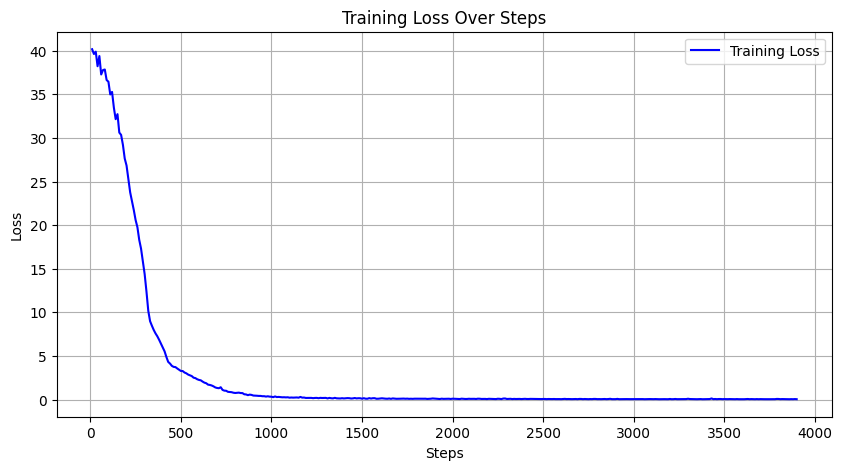

In [19]:
# 繪製訓練結果
log_history = trainer.state.log_history

# 提取步驟和損失
steps = []
losses = []

for entry in log_history:
    if "loss" in entry:
        steps.append(entry["step"])
        losses.append(entry["loss"])

# 繪製損失曲線
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label='Training Loss', color='blue')
plt.title('Training Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()  # 顯示圖形

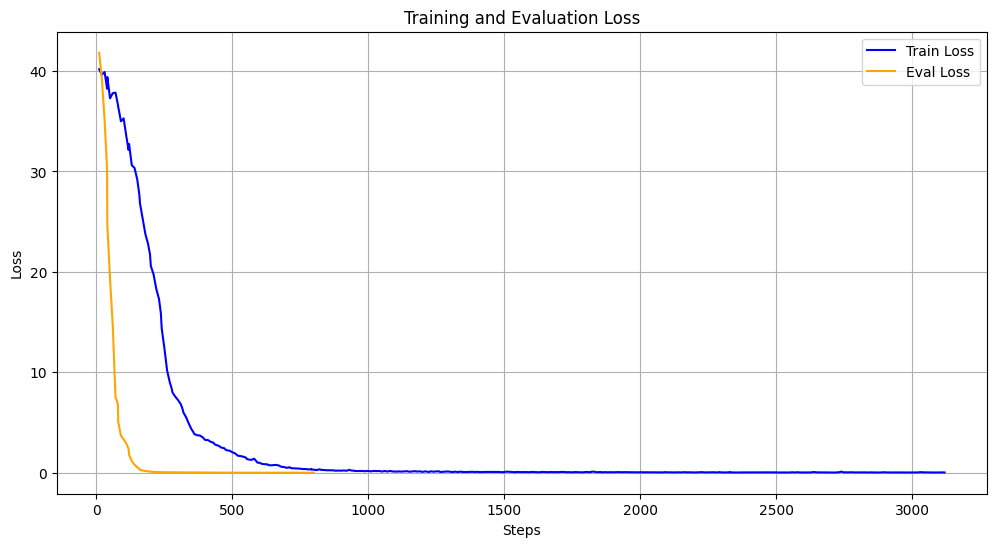

In [20]:
# 將 log_history 轉換為 DataFrame
log_history_df = pd.DataFrame(trainer.state.log_history)

# 提取訓練和驗證損失
train_losses = log_history_df['loss'].dropna().tolist()
eval_losses = log_history_df['eval_loss'].dropna().tolist()
steps = log_history_df['step'].dropna().tolist()

# 確保訓練損失和步驟匹配
train_steps = steps[:len(train_losses)]

plt.figure(figsize=(12, 6))

# 繪製訓練損失
plt.plot(train_steps, train_losses, label='Train Loss', color='blue')

# 繪製驗證損失（如果存在）
if eval_losses:
    eval_steps = steps[:len(eval_losses)]
    plt.plot(eval_steps, eval_losses, label='Eval Loss', color='orange')

plt.title('Training and Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [21]:
from peft import PeftModel, PeftConfig

peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

peft_model = PeftModel.from_pretrained(peft_model_base, 
                                       '../output/lora_weights', 
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

In [22]:
peft_model.print_trainable_parameters()

trainable params: 0 || all params: 304,200,960 || trainable%: 0.0000


In [23]:
device

'mps'

In [24]:
def split_text_into_chunks(text: str, chunk_size: int = 1000, overlap: int = 100):
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunk = text[start:end]
        chunks.append(chunk)
        start = end - overlap
    return chunks

def detect_has_transaction(chunk: str):
    prompt = f"classify transaction: {chunk}"
    # 將模型移到正確的設備
    peft_model.to(device)
    
    # 確保輸入數據在正確的設備上
    inputs = tokenizer(
        prompt, 
        max_length=512, 
        padding="max_length", 
        truncation=True, 
        return_tensors="pt"
    )
    
    # 手動將輸入移到設備上
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)
    
    # 使用 with torch.no_grad() 來避免梯度計算
    with torch.no_grad():
        outputs = peft_model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=1,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id
        )
    
    # 將輸出移回 CPU 進行解碼
    outputs = outputs.cpu()
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

df = pd.read_csv('../input/data2.csv')
results = []
for index, row in df.iterrows():
    chunks = split_text_into_chunks(row['Chunk'])
    for chunk in chunks:
        r = detect_has_transaction(chunk)
        results.append({
            'chunk': chunk,
            'result': r==1,
            'actual': row['Actual'],
            'correct': (r==1) == (row['Actual'] == True)
        })
df2 = pd.DataFrame(results)

In [25]:
total_rows = len(df2)
correct_count = df2['correct'].value_counts()[True] if True in df2['correct'].value_counts() else 0
correct_percentage = (correct_count / total_rows) * 100
no_of_positive_correct = df2[df2['actual'] == True]['correct'].value_counts()[True] if True in df2[df2['actual'] == True]['correct'].value_counts() else 0
no_of_negative_correct = df2[df2['actual'] == False]['correct'].value_counts()[True] if True in df2[df2['actual'] == False]['correct'].value_counts() else 0
no_of_positive = df2['actual'].value_counts()[True] if True in df2['actual'].value_counts() else 0
no_of_negative = df2['actual'].value_counts()[False] if False in df2['actual'].value_counts() else 0
positive_accuracy = no_of_positive_correct / no_of_positive * 100
negative_accuracy = no_of_negative_correct / no_of_negative * 100

print(f"Total rows: {total_rows}")
print(f"Number of correct rows: {correct_count}")
print(f"Percentage correct: {correct_percentage:.2f}%")
print(f"Number of positive: {no_of_positive}")
print(f"Number of negative: {no_of_negative}")
print(f"Number of positive correct: {no_of_positive_correct}")
print(f"Number of negative correct: {no_of_negative_correct}")
print(f"Positive accuracy: {positive_accuracy:.2f}%")
print(f"Negative accuracy: {negative_accuracy:.2f}%")

display(df2)

Total rows: 564
Number of correct rows: 472
Percentage correct: 83.69%
Number of positive: 92
Number of negative: 472
Number of positive correct: 0
Number of negative correct: 472
Positive accuracy: 0.00%
Negative accuracy: 100.00%


,chunk,result,actual,correct
0,"AEON CREDIT SERVICE (ASIA) CO., LTD. SAEON AEO...",False,False,True
1,code 商戶編號:9326) 5. PAYMENT AT CONVENIENCE STO...,False,False,True
2,code 商戶編號:9326) 5. PAYMENT AT CONVENIENCE STO...,False,False,True
3,"結單後60日仍未收到閣下之查詢,一切賬項均作實論。 Remark 備註:(P)-Princi...",False,False,True
4,"結單後60日仍未收到閣下之查詢,一切賬項均作實論。 Remark 備註:(P)-Princi...",False,True,False
...,...,...,...,...
559,ment Due | about... and you will end up paying...,False,False,True
560,our account 068-0-039716 will be debited HKD 3...,False,False,True
561,our account 068-0-039716 will be debited HKD 3...,False,False,True
562,"額 信貸安排,請填妥結單頁之表格或透過個人網上理財服務 作出指示。如有任何查詢,請致電223...",False,False,True
